# eBOSS ELG with DECaLS DR5

## 1.

In [1]:
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/global/homes/m/mehdi/github/DESILSS')
from counter import paircount

In [3]:
import healpy as hp

In [4]:
import numpy as np

In [5]:
def XI(theta, phi, delta1, delta2, weight, bins):
    bins_rad = np.deg2rad(bins)
    w = paircount(theta, phi, delta1, delta2, weight, bins_rad)
    binc = 0.5*(bins[1:]+bins[:-1])
    return [binc, w[0], w[1], w[2], w[3], w[4], w[5]]

In [6]:
from time import time

In [22]:
class XI_JACK(object):
    def __init__(self, elgmap, ranmap, select_fun, mask, njack=20):
        self.nside = hp.get_nside(elgmap)
        delta = np.zeros(elgmap.size)
        randc = ranmap * select_fun
        sf    = (elgmap[mask].sum() / randc[mask].sum())
        delta[mask] = elgmap[mask] / randc[mask] / sf - 1
        w = ranmap[mask]
        theta, phi = hp.pix2ang(self.nside, np.argwhere(mask).flatten())
        thetal, phil, wl, deltal,_ = split_jackknife(theta, phi, w, delta[mask], delta[mask], njack=njack)
        self.theta  = thetal
        self.phi    = phil
        self.weight = wl
        self.delta  = deltal
    def run(self):
        bw = 3.*hp.nside2resol(self.nside)*180./3.1416  # 3x resol.
        bins = np.arange(bw, 10, bw)
        njack = len(self.theta)
        print('njack ', njack)
        self.result = dict()
        for m in range(njack):
            t  = self.theta[m].copy()
            p  = self.phi[m].copy()
            w  = self.weight[m].copy()
            d  = self.delta[m].copy()
            t1 = time()
            self.result[m] = XI(t, p, d, d, w, bins)
            print('sample{} done in {} s'.format(m, time()-t1))
        #
        #
        nbins = len(bins)-1
        xijackl = []
        for i in range(njack): # jackknife
            wa = np.zeros(nbins)
            wb = np.zeros(nbins)
            wa1 = np.zeros(nbins)
            wb1 = np.zeros(nbins)
            wa2 = np.zeros(nbins)
            wb2 = np.zeros(nbins)            
            for j in range(njack): 
                if j!=i:
                    wa += self.result[j][1]
                    wb += self.result[j][2]
                    wa1 += self.result[j][3]
                    wb1 += self.result[j][4]
                    wa2 += self.result[j][5]
                    wb2 += self.result[j][6]                    
            xijackl.append(wa/wb - (wa1/wb1)*(wa2/wb2))

        wa = np.zeros(nbins)
        wb = np.zeros(nbins)
        wa1 = np.zeros(nbins)
        wb1 = np.zeros(nbins)
        wa2 = np.zeros(nbins)
        wb2 = np.zeros(nbins)            
        for j in range(njack): 
            wa += self.result[j][1]
            wb += self.result[j][2]
            wa1 += self.result[j][3]
            wb1 += self.result[j][4]
            wa2 += self.result[j][5]
            wb2 += self.result[j][6]                    
        xiall  = wa/wb - (wa1/wb1)*(wa2/wb2)
        var = np.zeros(nbins)
        for i in range(njack):
            var += (xiall - xijackl[i])**2
        var *= (njack-1)/njack
        self.output = dict(alls=self.result, t=0.5*(bins[:-1]+bins[1:]),
                           njack=njack, w=xiall, werr=np.sqrt(var), 
                           wjacks=xijackl, nside=self.nside)
        
        
class XI_JACK_cross(object):
    def __init__(self, elgmap, ranmap, select_fun, sysm, mask, njack=20):
        self.nside = hp.get_nside(elgmap)
        delta = np.zeros(elgmap.size)
        randc = ranmap * select_fun
        sf    = (elgmap[mask].sum() / randc[mask].sum())
        delta[mask] = elgmap[mask] / randc[mask] / sf - 1
        #
        #
        delta2 = np.zeros(elgmap.size)
        sf2  = (sysm[mask]*ranmap[mask]).sum() / ranmap[mask].sum()
        delta2[mask] = sysm[mask] / (sf2 * ranmap[mask]) - 1.0
        #
        #
        w = ranmap[mask]
        theta, phi = hp.pix2ang(self.nside, np.argwhere(mask).flatten())
        thetal, phil, wl, deltal, delta2l = split_jackknife(theta, phi, w, delta[mask], delta2[mask], njack=njack)
        self.theta  = thetal
        self.phi    = phil
        self.weight = wl
        self.delta  = deltal
        self.delta2 = delta2l
        
    def run(self):
        bw = 3.*hp.nside2resol(self.nside)*180./3.1416  # 3x resol.
        bins = np.arange(bw, 10, bw)
        njack = len(self.theta)
        self.result = dict()
        for m in range(njack):
            t  = self.theta[m].copy()
            p  = self.phi[m].copy()
            w  = self.weight[m].copy()
            d  = self.delta[m].copy()
            d2 = self.delta2[m].copy()
            t1 = time()
            self.result[m] = XI(t, p, d, d2, w, bins)
            print('sample{} done in {} s'.format(m, time()-t1))
        #
        nbins = len(bins)-1
        xijackl = []
        for i in range(njack): # jackknife
            wa = np.zeros(nbins)
            wb = np.zeros(nbins)
            wa1 = np.zeros(nbins)
            wb1 = np.zeros(nbins)
            wa2 = np.zeros(nbins)
            wb2 = np.zeros(nbins)            
            for j in range(njack): 
                if j!=i:
                    wa += self.result[j][1]
                    wb += self.result[j][2]
                    wa1 += self.result[j][3]
                    wb1 += self.result[j][4]
                    wa2 += self.result[j][5]
                    wb2 += self.result[j][6]                    
            xijackl.append(wa/wb - (wa1/wb1)*(wa2/wb2))

        wa = np.zeros(nbins)
        wb = np.zeros(nbins)
        wa1 = np.zeros(nbins)
        wb1 = np.zeros(nbins)
        wa2 = np.zeros(nbins)
        wb2 = np.zeros(nbins)            
        for j in range(njack): 
            wa += self.result[j][1]
            wb += self.result[j][2]
            wa1 += self.result[j][3]
            wb1 += self.result[j][4]
            wa2 += self.result[j][5]
            wb2 += self.result[j][6]                    
        xiall  = wa/wb - (wa1/wb1)*(wa2/wb2)
        var = np.zeros(nbins)
        for i in range(njack):
            var += (xiall - xijackl[i])**2
        var *= (njack-1)/njack
        self.output = dict(alls=self.result, t=0.5*(bins[:-1]+bins[1:]),
                           njack=njack, w=xiall, werr=np.sqrt(var), 
                           wjacks=xijackl, nside=self.nside)


In [8]:
from xi import split_jackknife

In [9]:
# read elgmap and ranmap
elgmap = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/eboss/eBOSS.ELGhpmap.fits')
ranmap = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/eboss/eBOSS.ELGRANhpmap.fits')
select_fun = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/march22/nn-weights-hpmap256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [10]:
mask = ranmap > 0.2

In [12]:
xijack = XI_JACK(elgmap, ranmap, select_fun, mask)
xijack.run()

njack  20
sample0 done in 1.0787346363067627 s
sample1 done in 0.9296562671661377 s
sample2 done in 0.9396138191223145 s
sample3 done in 0.8787496089935303 s
sample4 done in 0.8625388145446777 s
sample5 done in 0.8675663471221924 s
sample6 done in 0.8669331073760986 s
sample7 done in 0.8789505958557129 s
sample8 done in 0.8060140609741211 s
sample9 done in 0.8266425132751465 s
sample10 done in 0.8203856945037842 s
sample11 done in 0.7798025608062744 s
sample12 done in 0.762861967086792 s
sample13 done in 0.746408224105835 s
sample14 done in 0.75179123878479 s
sample15 done in 0.758725643157959 s
sample16 done in 0.8099517822265625 s
sample17 done in 0.8465931415557861 s
sample18 done in 0.9191372394561768 s
sample19 done in 1.1037266254425049 s


In [51]:
d = np.concatenate(xijack.delta)
w = np.concatenate(xijack.weight)
np.sum(d * w)/np.sum(w)

-0.00083927769011645371

In [13]:
xijack.output.keys()

dict_keys(['alls', 't', 'njack', 'w', 'werr', 'wjacks', 'nside'])

In [14]:
#np.save('/global/cscratch1/sd/mehdi/dr5_anand/march22/xi-dr5-jack256-nn', xijack.output)
np.save('/global/cscratch1/sd/mehdi/dr5_anand/march22/xi-dr5-jack256-nn-sub', xijack.output)

In [43]:
nn  = np.load('/global/cscratch1/sd/mehdi/dr5_anand/march22/xi-dr5-jack256-nn.npy').item()
nns = np.load('/global/cscratch1/sd/mehdi/dr5_anand/march22/xi-dr5-jack256-nn-sub.npy').item()

Text(0.5,0,'$\\theta[deg]$')

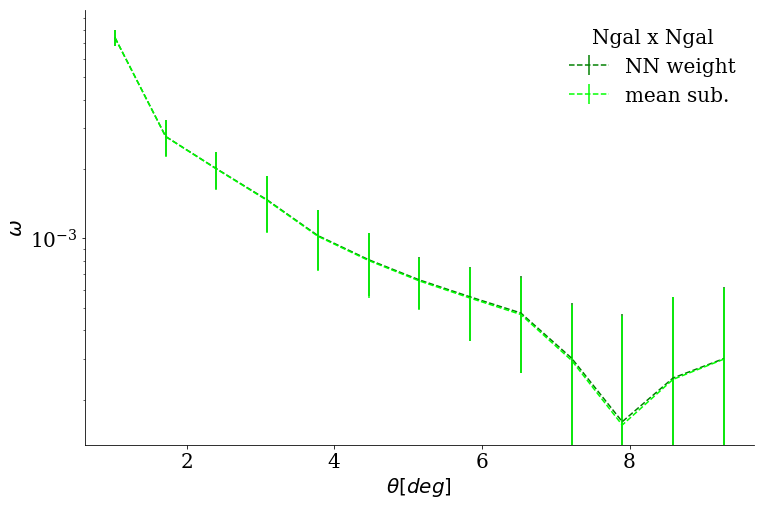

In [44]:
plt.figure(figsize=(12,8))
plt.rc('font', size=20, family='serif')
plt.rc('axes.spines', right=False, top=False)
# for i in range(20):
#     b = nn['t']
#     plt.plot(nn['t'], b*nn['wjacks'][i], 'g', alpha=0.2)
#     plt.plot(lin['t'], b*lin['wjacks'][i], 'r', alpha=0.2)
#     plt.plot(uni['t'], b*uni['wjacks'][i], 'b', alpha=0.2)

# 
pl = ['uni','lin']
c  = ['green', 'lime', 'green', 'lightblue', 'violet', 'lightgreen']
l  = ['NN weight', 'mean sub.', None, None, None]
for i,s in enumerate([nn, nns]):
    b = s['t']
    plt.errorbar(b, s['w'], 
             yerr=s['werr'], ls='--', color=c[i],
            label=l[i])

plt.legend(frameon=False, title='Ngal x Ngal')
plt.axis()
plt.yscale('log')
plt.ylabel(r'$ \omega$')
plt.xlabel(r'$\theta[deg]$')
# plt.savefig('./figs/xi-ngal.pdf', bbox_inches='tight')

In [17]:
import fitsio as ft

In [18]:
ls /global/cscratch1/sd/mehdi/dr5_anand/eboss/sysmaps256

EBV.dr5.hpmap256.fits        depth-z.dr5.hpmap256.fits
airmass-g.dr5.hpmap256.fits  nstar.dr5.hpmap256.fits
airmass-r.dr5.hpmap256.fits  seeing-g.dr5.hpmap256.fits
airmass-z.dr5.hpmap256.fits  seeing-r.dr5.hpmap256.fits
depth-g.dr5.hpmap256.fits    seeing-z.dr5.hpmap256.fits
depth-r.dr5.hpmap256.fits


In [19]:
mask2 = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/eboss/dr5hpmask256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [20]:
np.array_equal(mask, mask2)

True

In [21]:
depthr = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/eboss/sysmaps256/depth-r.dr5.hpmap256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [23]:
xijackd = XI_JACK_cross(elgmap, ranmap, select_fun, depthr, mask)
xijackd.run()

sample0 done in 1.1938483715057373 s
sample1 done in 1.0350961685180664 s
sample2 done in 1.0531682968139648 s
sample3 done in 0.9895527362823486 s
sample4 done in 0.921872615814209 s
sample5 done in 0.934593915939331 s
sample6 done in 0.9821133613586426 s
sample7 done in 0.9164638519287109 s
sample8 done in 0.8587214946746826 s
sample9 done in 0.8805913925170898 s
sample10 done in 0.9151060581207275 s
sample11 done in 0.845012903213501 s
sample12 done in 0.8381528854370117 s
sample13 done in 0.8156116008758545 s
sample14 done in 0.7945654392242432 s
sample15 done in 0.8385283946990967 s
sample16 done in 0.9010567665100098 s
sample17 done in 0.8852388858795166 s
sample18 done in 0.9762222766876221 s
sample19 done in 1.227306842803955 s


In [24]:
np.save('/global/cscratch1/sd/mehdi/dr5_anand/march22/xi-ngaldepthr-dr5-jack256-nn-sub', xijackd.output)

In [48]:
# lin = np.load('/global/cscratch1/sd/mehdi/dr5_anand/april3/xi-ebossdr5-cross-ngaldepth-r-lin_nside_256_njack_20.npy').item()
nn  = np.load('/global/cscratch1/sd/mehdi/dr5_anand/april3/xi-ebossdr5-cross-ngaldepth-r-nn_nside_256_njack_20.npy').item()
nns = np.load('/global/cscratch1/sd/mehdi/dr5_anand/march22/xi-ngaldepthr-dr5-jack256-nn-sub.npy').item()

Text(0.5,0,'$\\theta[deg]$')

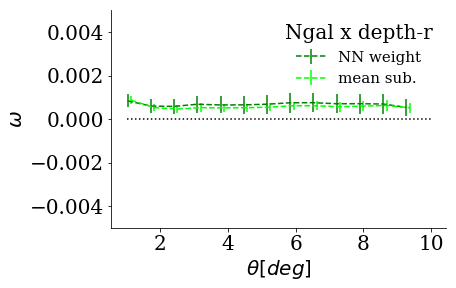

In [68]:
pl = ['uni','lin']
c  = ['green','lime', 'red', 'lightblue', 'violet', 'lightgreen']
l  = ['NN weight', 'mean sub.', 'lin', None, None]
for i,s in enumerate([nn, nns]):
    b = s['t']
    if i == 1:
        f = .0001#084
    else:
        f = 0.
    plt.errorbar(b+0.1*i, f+s['w'], 
             yerr=s['werr'], ls='--', color=c[i],
            label=l[i])

plt.legend(frameon=False, title='Ngal x depth-r', fontsize=15)
plt.axis()
# plt.yscale('log')
plt.plot([1, 10], [0,0], 'k:')
plt.ylim(-0.005, 0.005)
plt.ylabel(r'$ \omega$')
plt.xlabel(r'$\theta[deg]$')

In [55]:
d = np.concatenate(xijackd.delta)
d2 = np.concatenate(xijackd.delta2)
w = np.concatenate(xijackd.weight)
np.sum(d * w)/np.sum(w), np.sum(d2 * w)/np.sum(w)


(-0.00083927769011645371, 0.10033407151957963)

# Subtracting the global mean

In [1]:
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/global/homes/m/mehdi/github/DESILSS')

In [3]:
import healpy as hp

In [4]:
# read elgmap and ranmap
elgmap = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/eboss/eBOSS.ELGhpmap.fits')
ranmap = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/eboss/eBOSS.ELGRANhpmap.fits')
select_fun = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/march22/nn-weights-hpmap256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [5]:
mask = ranmap > 0.2

In [6]:
import xi

In [7]:
xijack = xi.XI_JACK(elgmap, ranmap, select_fun, mask)
xijack.run()

njack  20
sample0 done in 1.1189677715301514 s
sample1 done in 0.9687259197235107 s
sample2 done in 0.9523248672485352 s
sample3 done in 0.9050469398498535 s
sample4 done in 0.8868515491485596 s
sample5 done in 0.8831722736358643 s
sample6 done in 0.9080836772918701 s
sample7 done in 0.8620831966400146 s
sample8 done in 0.8313279151916504 s
sample9 done in 0.8691844940185547 s
sample10 done in 0.870124101638794 s
sample11 done in 0.8361454010009766 s
sample12 done in 0.802133321762085 s
sample13 done in 0.7808656692504883 s
sample14 done in 0.7712242603302002 s
sample15 done in 0.785132884979248 s
sample16 done in 0.8235683441162109 s
sample17 done in 0.8898541927337646 s
sample18 done in 1.0219943523406982 s
sample19 done in 1.1351072788238525 s


In [13]:
xijack.output.keys()

dict_keys(['alls', 't', 'njack', 'w', 'werr', 'wjacks', 'nside', 'dmean'])

In [11]:
import numpy as np

In [12]:
nn  = np.load('/global/cscratch1/sd/mehdi/dr5_anand/march22/xi-dr5-jack256-nn.npy').item()
nn['w']

array([ 0.00741934,  0.00276482,  0.00200476,  0.00146786,  0.00102769,
        0.00080781,  0.00066014,  0.0005574 ,  0.00047455,  0.00030245,
        0.00016023,  0.00024783,  0.00030078])

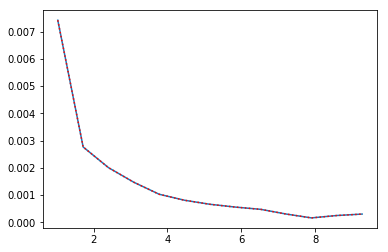

In [16]:
plt.plot(nn['t'], nn['w'])
plt.plot(xijack.output['t'], xijack.output['w']-xijack.output['dmean']**2, 'r:')

In [17]:
xijack.output['dmean']**2

7.1836812583793811e-07